# Best Customer Analysis


Author: Yue Ling

Year: 2022


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [2]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2


# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [3]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)
cursor = connection.cursor()

In [4]:
# customers who have signed up but not bought anything yet -- good for traffic flow (at least once)
rollback_before_flag = True
rollback_after_flag = True

#will join with sales, if not bought anything, total_amount would be 0 
query = """

select sum(sa.total_amount) as total_amount, c.last_name, c.first_name
from customers c
left outer join sales sa
on sa.customer_id = c.customer_id 
where sa.total_amount is null
group by 2,3
order by 2,3

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_amount,last_name,first_name
0,None,Agott,Tracy
1,None,Arnke,Daniella
2,None,Assandri,Hyacintha
3,None,Borman,Felice
4,None,Breit,Domini
5,None,Butterick,Jacenta
6,None,Camillo,Marysa
7,None,Dukelow,Lilas
8,None,Dukesbury,Corinna
9,None,Ellaway,Lorianna


In [5]:
# most recent customers first// metric for best customer
rollback_before_flag = True
rollback_after_flag = True
# For inspiration: https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/ 
query = """

select c.customer_id , max(sa.sale_date) as most_recent_purchase_date
from customers c
    join sales sa
        on c.customer_id = sa.customer_id
group by 1
order by 2 desc

"""
#Note: just do recency on its own, don't need to include max spent. Do max() date, to get most recent

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)


,customer_id,most_recent_purchase_date
0,6155,2020-12-31
1,2587,2020-12-31
2,14243,2020-12-31
3,7395,2020-12-31
4,3665,2020-12-31
...,...,...
31042,19968,2020-10-05
31043,6556,2020-10-03
31044,19664,2020-10-02
31045,5254,2020-10-01


In [6]:
# this is most frequent as "best customer" shown first
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id , count(sa.sale_date) as num_visits, sum(sa.total_amount) as total_spent
from customers c
    join sales sa
        on c.customer_id = sa.customer_id

group by 1
having count(sa.sale_date) >= 1

order by 2 desc

"""
# customers who have bought something // 31047, customers who have never bought something: 35
# cuz doing join, only have sales more than 1 
df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer_id,num_visits,total_spent
0,28918,123,7836
1,27728,122,7752
2,27674,120,7620
3,27471,119,6972
4,27762,119,7848
...,...,...,...
31042,6174,12,912
31043,15264,12,708
31044,9828,12,840
31045,13465,11,768


In [7]:
# this is most money spent as "best customer" shown first
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id , count(sa.sale_date) as num_visits, sum(sa.total_amount) as total_spent
from customers c
    join sales sa
        on c.customer_id = sa.customer_id

group by 1
having count(sa.sale_date) >= 1

order by 3 desc

"""
# customers who have bought something // 31047, customers who have never bought something: 35
# cuz doing join, only have sales more than 1 
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)


,customer_id,num_visits,total_spent
0,30772,110,8328
1,30775,108,7908
2,30692,100,7860
3,30323,106,7848
4,28543,108,7848
...,...,...,...
31042,15264,12,708
31043,1528,16,684
31044,12861,14,672
31045,22530,14,648


In [10]:
# maybe not as imp // avg spend // dilutes the info about number of times visited or the amount of money spent
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id ,  sum(sa.total_amount) / count(sa.sale_date) as avg_spend_per_visit, 
    count(sa.sale_date) as num_visits
from customers c
    join sales sa
        on c.customer_id = sa.customer_id

group by 1
having count(sa.sale_date) >= 1

order by 2 desc

"""
# customers who have bought something // 31047, customers who have never bought something: 35
# cuz doing join, only have sales more than 1 
df1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df1

,customer_id,avg_spend_per_visit,num_visits
0,20437,99.789474,19
1,26415,97.411765,17
2,7221,97.000000,24
3,6742,96.521739,23
4,20742,95.172414,29
...,...,...,...
31042,17646,41.250000,32
31043,28241,41.217391,46
31044,22515,41.000000,24
31045,961,38.181818,22


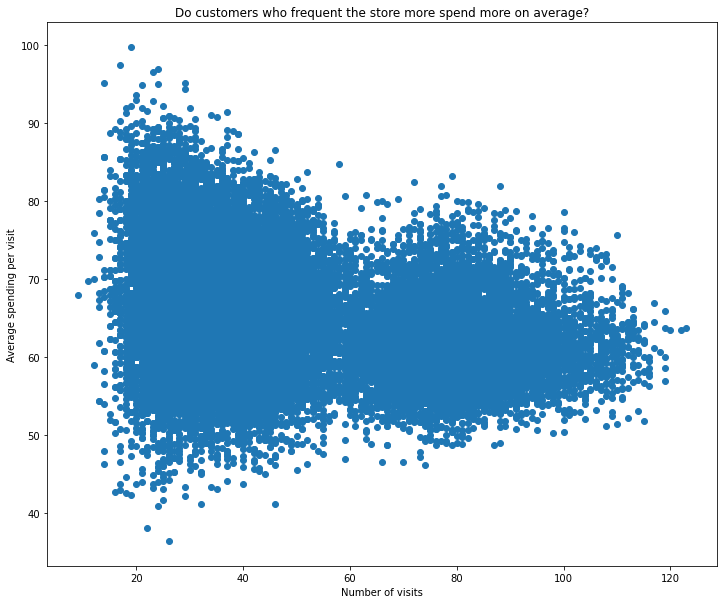

In [11]:
plt.figure (figsize=(12,10))
plt.scatter(df1.num_visits, df1.avg_spend_per_visit)
plt.title('Do customers who frequent the store more spend more on average?')
plt.ylabel('Average spending per visit')
plt.xlabel('Number of visits')
plt.show()

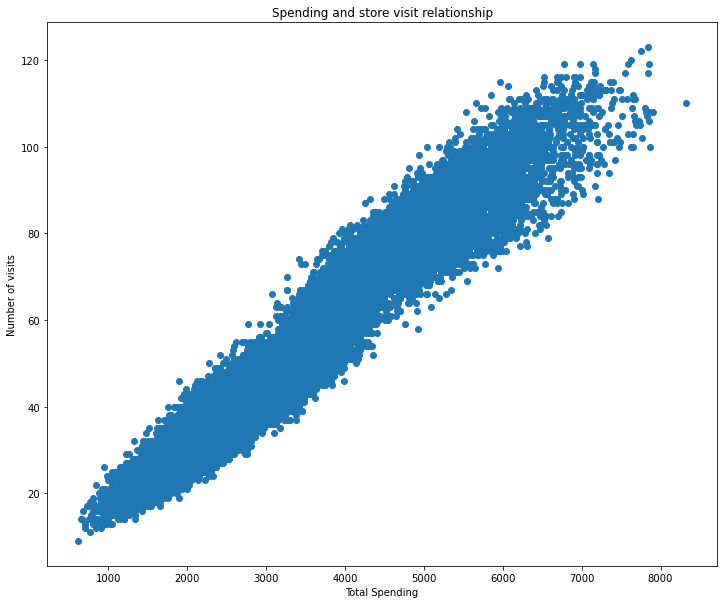

In [9]:
plt.figure (figsize=(12,10))
plt.scatter(df.total_spent, df.num_visits)
plt.title('Spending and store visit relationship')
plt.xlabel('Total Spending')
plt.ylabel('Number of visits')
plt.show()

# Executive Summary

The 3 metrics important for our model for determining the best customers are recency, frequency, monetary. The best customers are the ones that are valued more in our following metrics. 

First, we will look at recency - when was the last time the customer visited. We would not place the same value on a customer who's visited many years ago versus a customer who's visited yesterday. The not-so-recent customer may have moved and never visit our store for all we know. Looking at AGM's customers who have made at least 1 purchase, the most not-so-recent customer would be about 3 months from the most recent customer. This means that we can do a normalization of their recency rating based on the time difference between most and least recent customer over their actual time. 

I would argue that the frequency of a customer is a slightly more important metric than recency and monetary. Not only would the stores have a better public image with more customers, but also the stores have tactics to drive up sales once the customers come in. For example, the aromas of the great food, seeing other customers snatching up the valued items, the appeal of the way food is set, the customers' sunk cost of having to come to the stores -- all of these are drivers for getting the customer to buy something. Some strategies are recommended in Project 1.6 that further elaborates on this point.  

Lastly, customers who spend more are "higher valued" customers. Customers who come into the stores, but don't spend any money are not doing anything to better the business. In fact they could be hurting the business by taking up real-estate and pumping up the electricity bills from opening the sensor-activated electronic doors to name a few. Customers who spend more would be weighted as more beneficial to the business.   

## Figure Explanation

I observe the customers that frequently visits the store usually spends the same amount of money per visit of around $62. In contrast, people who visit the store less frequently have a big spread in their average spending. This shows that they could be classified into 2 groups: high spending, but infrequent shoppers or infrequent and non-loyal customers. 

There is a linear positive relation between more spending correlated with more store visits.  Both of these metrics are equally as important in determining the best customers. Ranking the biggest spenders first and ranking the most frequent-visting customers first, the number of visits and money spent are fairly similar with small deviations. Therefore, we may consider both frequency and monetary equally as relevent in our model building for considering the "best customers".  We also observe much more deviations in spending when the customers have visited more times. Whereas, the customers that don't frequent the stores do not spend as much and have similar spending habits to other counterparts who don't frequent the stores much.



